
# Making AI Answers More Reliable  
*Session 2: Building a Retrieval‑Augmented Generation (RAG) System

**Flow:** Introduction → Demo → Exercise → Reflection



## 🧪 Introduction

LLMs can answer fluently but sometimes produce **confident mistakes** (*hallucinations*).  
**Retrieval‑Augmented Generation (RAG)** reduces errors by first **retrieving** relevant text from documents and then having the model answer **using that evidence**.

What you will do:
1) **Demo:** Compare a **Plain LLM** answer vs **RAG** on the same question (*“What are the applications of aspirin?”*) over a tiny pre‑loaded mini‑corpus.  
2) **Exercise:** Upload a PDF of your choice (a paper you’re interested in), optionally adjust the file path, and **run RAG** to generate answers.


> **Why grounding helps:** Models can invent details.

 “Just like in this cartoon, LLMs can sometimes invent or leak details. That's risky in chemistry — we don't want a model making up a reaction condition in the lab!”

Transition: “This is why we bring in RAG: instead of trusting the model's memory, we tie answers to real evidence from documents, so we can see exactly where an answer came from.” RAG ties answers to real text.!

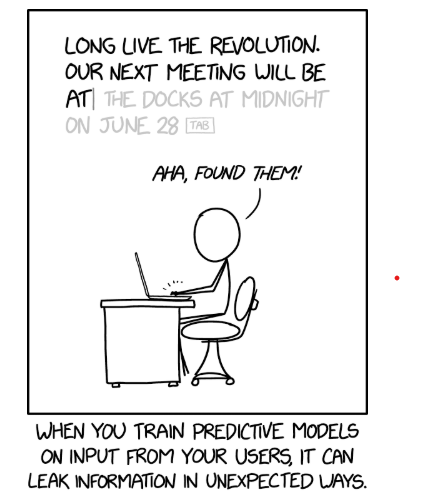


## ✅ Setup (Run this once)

1) Install libraries and import.  
2) Add your **OpenAI API key** (hidden input).  
3) If you skip the key, we will show a safe placeholder so the notebook still runs.


In [ ]:

!pip -q install ipywidgets langchain langchain-community langchain-openai faiss-cpu pypdf tiktoken

import os, io
import ipywidgets as widgets
from IPython.display import display, Markdown

# LangChain imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings  # OpenAI chat model + embeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Smart text chunking
from langchain_community.document_loaders import PyPDFLoader  # PDF loader -> documents
from langchain.chains import RetrievalQA   # Simple retrieval+QA chain


### 🔑 Add your OpenAI API key

In [ ]:

api_key_box = widgets.Password(description='API Key:', placeholder='sk-...', layout=widgets.Layout(width='40%'))
save_btn = widgets.Button(description='Save Key', button_style='primary')
status = widgets.HTML("")

def _save_key(_):
    if api_key_box.value.strip():
        os.environ["OPENAI_API_KEY"] = api_key_box.value.strip()
        status.value = "<span style='color:green'>✅ Key saved for this session.</span>"
    else:
        status.value = "<span style='color:#B00020'>⚠️ Please paste a valid key.</span>"

save_btn.on_click(_save_key)
display(widgets.HBox([api_key_box, save_btn]), status)



## 🧩 What the next cells provide

- **Plain LLM** (no retrieval) for baseline comparison.  
- **RAG pipeline (LangChain):** split → embed → FAISS vector store → retrieve → generate.  
- Minimal widgets to run the demo and exercise.


In [ ]:

def plain_llm_answer(question: str, model: str = "gpt-4o-mini") -> str:

  """
    Ask the OpenAI chat model directly (no retrieval).
    Returns a placeholder if no API key is set.
    """
    if "OPENAI_API_KEY" not in os.environ:
        return ("*(Demo mode: no API key found.)*\n\n"
                "This is a placeholder answer. With a real key, the model would respond here.")
    llm = ChatOpenAI(model=model)   # Create a chat model client (uses env key)
    resp = llm.invoke(question)    # Call the model with the question
    return resp.content.strip()     # Extract and clean the text content


In [ ]:

def build_vectorstore_from_texts(texts, chunk_size=900, chunk_overlap=150):

   """
    Split input texts into overlapping chunks, embed them, and build a FAISS index.
    Returns a LangChain VectorStore (FAISS).
    """

    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    from langchain.docstore.document import Document
    docs = splitter.split_documents([Document(page_content=t) for t in texts])
    embeddings = OpenAIEmbeddings()
    vectordb = FAISS.from_documents(docs, embeddings)
    return vectordb

def rag_answer(question: str, retriever, model: str = "gpt-4o-mini"):

  """
    Use a RetrievalQA chain:
    - retrieves top-k chunks via 'retriever'
    - asks the chat model to answer using those chunks
    Returns (answer_text, source_documents_list).
    """

    if "OPENAI_API_KEY" not in os.environ:
        return ("*(Demo mode: no API key found.)*\n\n"
                "This is a placeholder RAG answer."), []
    llm = ChatOpenAI(model=model)
    qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff", return_source_documents=True)
    resp = qa.invoke({"query": question})
    return resp["result"], resp.get("source_documents", [])



## 💡 Demo — Plain vs RAG on the same question

**Question:** “What are the applications of aspirin?”  
We compare:
- **Plain LLM** (no evidence), and  
- **RAG** over a pre‑loaded **mini‑corpus** (a short review‑style paragraph).


In [ ]:

SAMPLE_EXCERPT = (
    "Aspirin (acetylsalicylic acid) is widely used as an analgesic, antipyretic, and anti-inflammatory drug. "
    "At low doses it is used for antiplatelet effects to reduce the risk of arterial thrombosis and myocardial infarction. "
    "It is studied for chemopreventive roles in colorectal cancer and for post-operative pain. "
    "Adverse effects include gastrointestinal irritation and bleeding."
)

vectordb_demo = build_vectorstore_from_texts([SAMPLE_EXCERPT])
retriever_demo = vectordb_demo.as_retriever(search_kwargs={"k": 3})
question_demo = "What are the applications of aspirin?"

model_pick = widgets.Dropdown(
    options=[("gpt-4o-mini (fast)","gpt-4o-mini"),
             ("gpt-4o (quality)","gpt-4o"),
             ("gpt-3.5-turbo (legacy)","gpt-3.5-turbo")],
    value="gpt-4o-mini", description="Model:"
)
btn_plain = widgets.Button(description="Run Plain LLM", button_style="warning")
btn_rag   = widgets.Button(description="Run RAG",       button_style="success")
out_plain, out_rag, out_src = widgets.Output(), widgets.Output(), widgets.Output()

def _run_plain(_):
    out_plain.clear_output()
    with out_plain: display(Markdown("⏳ Asking plain LLM..."))
    ans = plain_llm_answer(question_demo, model=model_pick.value)
    out_plain.clear_output(); display(Markdown(f"### Plain LLM\n{ans}"))

def _run_rag(_):
    out_rag.clear_output(); out_src.clear_output()
    with out_rag: display(Markdown("⏳ Retrieving evidence + generating..."))
    ans, sources = rag_answer(question_demo, retriever_demo, model=model_pick.value)
    out_rag.clear_output(); display(Markdown(f"### RAG Answer\n{ans}"))    # Show grounded answer
    with out_src:
        display(Markdown("#### Retrieved Evidence"))
        for i, d in enumerate(sources, start=1):    # Loop over source docs
            snippet = d.page_content
            if len(snippet) > 600: snippet = snippet[:570] + "…"
            display(Markdown(f"**(E{i})** — {snippet}"))

btn_plain.on_click(_run_plain)
btn_rag.on_click(_run_rag)

display(widgets.VBox([model_pick, widgets.HBox([btn_plain, btn_rag]), widgets.HBox([out_plain, out_rag]), out_src]))



## ✍️ Exercise — Your Own PDF + Research Question

1) **Upload a PDF** (a paper you’re interested in).  
2) **Optionally change the file path** in the code to load manually.  
3) **Ask a research question** relevant to your PDF.  
4) Click **Run RAG on My PDF** and review the answer **and** the evidence.

**Guiding text:**  
“Think of a research question relevant to your PDF. Compare RAG’s answer with your own knowledge.”


In [ ]:

uploader = widgets.FileUpload(accept='.pdf', multiple=False)   # Widget to upload a single PDF
q_box = widgets.Textarea(placeholder="e.g., What mechanism is proposed?", layout=widgets.Layout(width="100%", height="80px"))  # Text box for the research question
k_slider = widgets.IntSlider(value=4, min=1, max=8, description='Top-k:')  # How many chunks to retrieve
model_ex = widgets.Dropdown(
    options=[("gpt-4o-mini (fast)","gpt-4o-mini"),
             ("gpt-4o (quality)","gpt-4o"),
             ("gpt-3.5-turbo (legacy)","gpt-3.5-turbo")],
    value="gpt-4o-mini", description="Model:"
)
btn_build = widgets.Button(description="Build Index", button_style="info")    # Build FAISS from uploaded PDF
btn_run   = widgets.Button(description="Run RAG on My PDF", button_style="primary")
out_build, out_ans, out_src = widgets.Output(), widgets.Output(), widgets.Output()

display(uploader, q_box, k_slider, model_ex, widgets.HBox([btn_build, btn_run]), out_build, out_ans, out_src)

_vectordb = {"db": None, "retriever": None}

def _build_index(_):
    out_build.clear_output()
    if uploader.value:
        key = list(uploader.value.keys())[0]
        pdf_bytes = uploader.value[key]['content']
        tmp_path = "/content/student_upload.pdf"
        with open(tmp_path, "wb") as f: f.write(pdf_bytes)
        loader = PyPDFLoader(tmp_path)
        docs = loader.load()
    else:
      # Instead of requiring upload, load from a manual file path
      file_path = "/content/student_upload.pdf"   # 🔄 change to your PDF path
      loader = PyPDFLoader(file_path)
      docs = loader.load()

    splitter = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150)
    chunks = splitter.split_documents(docs)
    db = FAISS.from_documents(chunks, OpenAIEmbeddings())
    _vectordb["db"] = db
    _vectordb["retriever"] = db.as_retriever(search_kwargs={"k": k_slider.value})
    with out_build: display(Markdown(f"✅ Index built with {len(chunks)} chunks."))

def _run_user(_):
    out_ans.clear_output(); out_src.clear_output()
    if not _vectordb["retriever"]:
        with out_ans: display(Markdown("*Build index first.*")); return
    question = q_box.value.strip()
    if not question:
        with out_ans: display(Markdown("*Enter a question.*")); return
    ans, sources = rag_answer(question, _vectordb["retriever"], model=model_ex.value)      # Ask RAG over student’s PDF
    out_ans.clear_output(); display(Markdown(f"### Answer (RAG)\n{ans}"))
    with out_src:
        display(Markdown("#### Retrieved Evidence"))
        for i, d in enumerate(sources, start=1):
            snippet = d.page_content
            if len(snippet) > 600: snippet = snippet[:570] + "…"
            display(Markdown(f"**(E{i})** — {snippet}"))

btn_build.on_click(_build_index)
btn_run.on_click(_run_user)



## 📘 Reflection
- Where did **RAG** clearly improve the answer vs **Plain LLM**?  
- Which details would you **verify** in the paper?  
- If evidence looked irrelevant, how would you **rephrase your question** or adjust **Top‑k**?
